In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load data

In [2]:
# Split according to distribution

df = pd.read_csv("data\LIACC\cpu_small_data.csv", ",")
df= df.fillna(0)

# Calculate Correlation between coloumns 
corr_values = []
highest_corr = 0
highest_col = 0

for col in df:
    corr = df["usr"].corr(df[col])
    corr_values.append(corr)
    if corr >= max(corr_values) and corr < 1.0:
        highest_corr = corr
        highest_col = col
    #print("Correlation between the target and "+ str(col) + " : " + str(corr))
    #print(highest_corr)

# Selecto Corr >= 0,4 and sort data accordingly 
print ("Column: "+str(highest_col)+ " has the highest correlation with the target: " + str(highest_corr))
df = df.sort_values(by=[highest_col], ascending = False)
df = df.reset_index(drop=True)

# Split df in 3 equal parts
split = int(len(df[:1000])/3)
df_1 = df.loc[0:split,:]
df_2 = df.loc[split:split*2,:]
df_3 = df.loc[split*2:split*3,:]
print("Df has been split into 3 equal parts: ",df_1.shape,df_2.shape,df_3.shape)

Column: freeswap has the highest correlation with the target: 0.6785262417399928
Df has been split into 3 equal parts:  (334, 13) (334, 13) (334, 13)


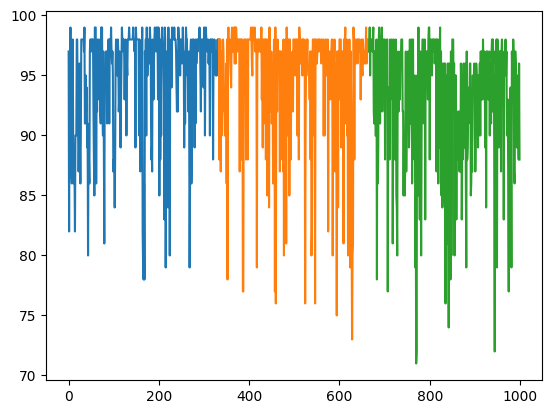

In [157]:
plt.plot(df_1["usr"])
plt.plot(df_2["usr"])
plt.plot(df_3["usr"])
#plt.xlim(0, len(Xt[:25]))
plt.show()

## Prepare Experiment

In [292]:
df_src = df_2 #.append(df_2)
#print(df_src.head(), df_src.shape)

df_tar = df_3
#print(df_tar.head(), df_tar.shape)

In [ ]:
'''df = pd.read_csv("Concrete_Data_2.csv", ";")

df = df.astype('float32')

pd.options.display.float_format = '{:,.2f}'.format
df.apply(lambda x: x.astype(int) if np.allclose(x, x.astype(int)) else x)
df = df.drop(columns="6.00")

df_src = df.loc[0:600,:]
#print(df_src.head(), df_src.shape)

df_tar = df.loc[601:1000,:]
#print(df_tar.head(), df_tar.shape)'''

In [293]:
# source
Xs = df_src.iloc[:,:-1]
Ys = df_src.iloc[:,-1]

# target_train
Xt = df_tar.iloc[:,:-1]
Yt = df_tar.iloc[:,-1]

## Metrics

In [2]:
from get_metrics import get_transferability_metrics

import sys
modname = globals()['__name__']
modobj  = sys.modules[modname]


sub_src_df_1 = ['df_1', 'df_2', 'df_1', 'df_3', 'df_1', 'df_2']
sub_tar_df_2 = ['df_1', 'df_1', 'df_2', 'df_2', 'df_3', 'df_3']

Values = []

for i in range (0,6):

        # get current src and tar

        df_src = getattr(modobj, sub_src_df_1[i])
        df_tar = getattr(modobj, sub_tar_df_2[i])
        
        save_values = get_transferability_metrics(df_src, df_tar)

        Values.append(save_values)

NameError: name 'modobj' is not defined

In [242]:
save_values

[32108.659524611965,
 0.013321170616371994,
 0.7832335329341319,
 0.09544910179640718,
 0.4056157630056601,
 nan]

# Models


## KMM

In [294]:
import sklearn
from TL_Regression_Methods.KMM import KMM
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

results_transfer = []
results_transfer_val = []

model = DecisionTreeRegressor(max_depth=5) #KNeighborsRegressor(n_neighbors=3) #linear_model.Lasso(alpha=15) #DecisionTreeRegressor(max_depth=5)
model.fit(Xs, Ys)
y_pre_kmm = model.predict(Xt[:25])
mse_kmm = mean_squared_error(Yt[:25], y_pre_kmm)

results_transfer.append(mse_kmm)
y_pre_ridge = model.predict(Xt[25:])
mse_kmm_val = sklearn.metrics.mean_squared_error(Yt[25:], y_pre_ridge)
results_transfer_val.append(mse_kmm_val)

'''plt.plot(Yt.reset_index(drop=True))
plt.plot(y_pre_kmm)
plt.xlim(0, len(Xt[:25]))
plt.title('KMM with MSE: '+ str(mse_kmm))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()'''

print("MSE Transfer Testdata: ", np.mean(results_transfer))
print("MSE Transfer Validationdata: ", np.mean(results_transfer_val))

MSE Transfer Testdata:  4.1781607828076925
MSE Transfer Validationdata:  7.715633202170663


## TwoStageTrAdaBoostR2

334 18 7
At step: 3
Binary search's goal not meeted! Value is set to be the available best!
Try reducing the search interval. Current stp interval: 1e-30
At step: 4
Binary search's goal not meeted! Value is set to be the available best!
Try reducing the search interval. Current stp interval: 1e-30
At step: 5
Binary search's goal not meeted! Value is set to be the available best!
Try reducing the search interval. Current stp interval: 1e-30
At step: 6
Binary search's goal not meeted! Value is set to be the available best!
Try reducing the search interval. Current stp interval: 1e-30
At step: 7
Binary search's goal not meeted! Value is set to be the available best!
Try reducing the search interval. Current stp interval: 1e-30
At step: 8
Binary search's goal not meeted! Value is set to be the available best!
Try reducing the search interval. Current stp interval: 1e-30
At step: 9
Binary search's goal not meeted! Value is set to be the available best!
Try reducing the search interval. Curr

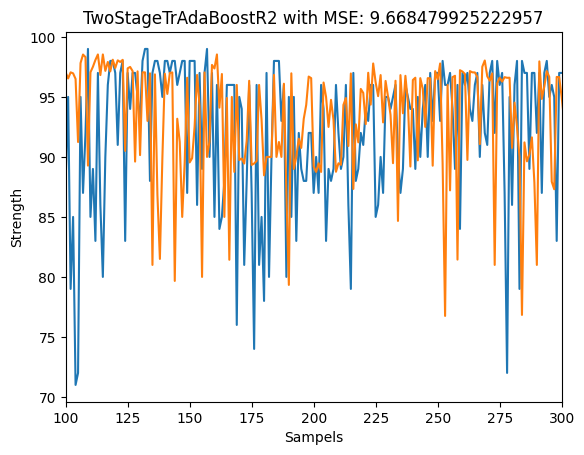

MSE Transfer Testdata:  9.668479925222957
MSE Transfer Validationdata:  6.315236930562324


In [295]:
from TL_Regression_Methods.TwoStageTrAdaBoostR2 import TwoStageTrAdaBoostR2
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

results_transfer = []
results_transfer_val = []

# Train Test Split
df_train, df_test= train_test_split(df_tar[:25], random_state=0)

# source
n_source1 = len(df_src)
x_source1 = df_src.iloc[:,:-1]
y_source1 = df_src.iloc[:,-1]

# target_train
n_target_train = len(df_train)
x_target_train = df_train.iloc[:,:-1]
y_target_train = df_train.iloc[:,-1]

# target_test
n_target_test = len(df_test)
x_target_test = df_test.iloc[:,:-1]
y_target_test = df_test.iloc[:,-1]

print(len(df_src),len(df_train),len(df_test))

for i in range(1, 2):
    # 4. transfer learning regressiong for the target_train data
    # 4.1 data combination and initial setting specification
    X = np.concatenate((x_source1, x_target_train))
    y = np.concatenate((y_source1, y_target_train))
    sample_size = [n_source1, n_target_train]

    n_estimators = 80
    steps = 10
    fold = 5
    random_state = np.random.RandomState(1)

    regr_1 = TwoStageTrAdaBoostR2( DecisionTreeRegressor(max_depth=5), #linear_model.Lasso(alpha=15), #KNeighborsRegressor(n_neighbors=3),
                        n_estimators = n_estimators, sample_size = sample_size, 
                        steps = steps, fold = fold, 
                        random_state = random_state)
    regr_1.fit(X, y)
    y_pre_twostageboost = regr_1.predict(x_target_test)
    mse_twostageboost = mean_squared_error(y_target_test, y_pre_twostageboost) 

    results_transfer.append(mse_twostageboost)

    y_pre_twostageboost = regr_1.predict(Xt[25:])
    mse_ridge_val = sklearn.metrics.mean_squared_error(Yt[25:], y_pre_twostageboost)
    results_transfer_val.append(mse_ridge_val)

plt.plot(df_tar.iloc[:,-1].reset_index(drop=True))
plt.plot(y_pre_twostageboost)
plt.xlim(100, 300)
plt.title('TwoStageTrAdaBoostR2 with MSE: '+ str(mse_twostageboost))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()

print("MSE Transfer Testdata: ", np.mean(results_transfer))
print("MSE Transfer Validationdata: ", np.mean(results_transfer_val))

# Baselines

## Baseline DecisionTreeRegressor

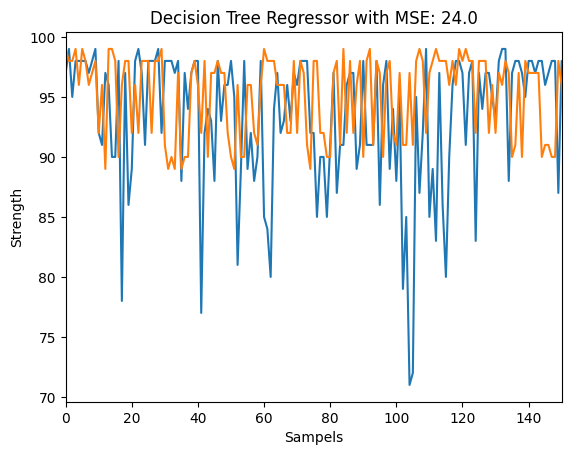

MSE Baseline Testdata:  24.76022972002872
MSE Baseline Validationdata:  29.909807939373245


In [245]:
import sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

results_transfer = []
results_transfer_val = []

# Train Test Split
X_train, X_test, y_train, y_test= train_test_split(Xt[:25], Yt[:25], random_state=0)

for i in range(1, 200):
    clf = DecisionTreeRegressor(max_depth=5)
    clf.fit(X_train, y_train)
    y_pre_ridge = clf.predict(X_test)
    mse_ridge = sklearn.metrics.mean_squared_error(y_test, y_pre_ridge)
    results_transfer.append(mse_ridge)

    y_pre_ridge = clf.predict(Xt[25:])
    mse_ridge_val = sklearn.metrics.mean_squared_error(Yt[25:], y_pre_ridge)
    results_transfer_val.append(mse_ridge_val)

plt.plot(df_tar.iloc[:,-1].reset_index(drop=True))
plt.plot(y_pre_ridge)
plt.xlim(0, 150)
plt.title('Decision Tree Regressor with MSE: '+ str(mse_ridge))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()

print("MSE Baseline Testdata: ", np.mean(results_transfer))
print("MSE Baseline Validationdata: ", np.mean(results_transfer_val))

## Baseline KNeighborsRegressor 

In [246]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

results_transfer = []
results_transfer_val = []

# Train Test Split
X_train, X_test, y_train, y_test= train_test_split(Xt[:25], Yt[:25], random_state=0)

for i in range(1, 200):
    clf = KNeighborsRegressor(n_neighbors=3)
    clf.fit(X_train, y_train)
    y_pre_ridge = clf.predict(X_test)
    mse_knr = sklearn.metrics.mean_squared_error(y_test, y_pre_ridge)

    results_transfer.append(mse_knr)

    y_pre_ridge = clf.predict(Xt[25:])
    mse_ridge_val = sklearn.metrics.mean_squared_error(Yt[25:], y_pre_ridge)
    results_transfer_val.append(mse_ridge_val)

'''plt.plot(y_test.reset_index(drop=True))
plt.plot(y_pre_ridge)
plt.xlim(0, len(y_test))
plt.title('KNeighborsRegressor: '+ str(mse_knr))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)'''

print("MSE Baseline Testdata: ", np.mean(results_transfer))
print("MSE Baseline Validationdata: ", np.mean(results_transfer_val))

MSE Baseline Testdata:  52.1428571428571
MSE Baseline Validationdata:  31.85185185185185


## Baseline Lasso

In [261]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

results_transfer = []
results_transfer_val = []

# Train Test Split
X_train, X_test, y_train, y_test= train_test_split(Xt[:25], Yt[:25], random_state=0)

for i in range(1, 200):
    clf = linear_model.Lasso(alpha=15)
    clf.fit(X_train, y_train)
    y_pre_ridge = clf.predict(X_test)
    mse_ridge = sklearn.metrics.mean_squared_error(y_test, y_pre_ridge)
    results_transfer.append(mse_ridge)

    y_pre_ridge = clf.predict(Xt[25:])
    mse_ridge_val = sklearn.metrics.mean_squared_error(Yt[25:], y_pre_ridge)
    results_transfer_val.append(mse_ridge_val)

'''plt.plot(y_test.reset_index(drop=True))
plt.plot(y_pre_ridge)
plt.xlim(0, len(y_target_test))
plt.title('Decision Tree Regressor with MSE: '+ str(mse_ridge))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()'''

print("MSE Baseline Testdata: ", np.mean(results_transfer))
print("MSE Baseline Validationdata: ", np.mean(results_transfer_val))

MSE Baseline Testdata:  104.61284040842571
MSE Baseline Validationdata:  53.69764798923363


# Visulization

In [ ]:
#from TL_Regression_Methods.KMM import KMM
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

#BDA
bda = BDA(kernel_type='primal', dim=30, lamb=1, mu=0.5, mode='BDA', gamma=1, estimate_mu=False)
mse_bda, y_pre_bda, list_acc = bda.fit_predict(Xs, Ys, Xt, Yt)

#JDA
jda = JDA(kernel_type='primal', dim=30, lamb=1, gamma=1)
mse_jda, y_pre_jda, list_acc = jda.fit_predict(Xs, Ys, Xt, Yt)

#Coral
coral = CORAL()
k = 1
mse_coral, y_pre_coral = coral.fit_predict(Xs, Ys, Xt, Yt, k)

#KMM
model = KNeighborsRegressor(n_neighbors=7)
model.fit(Xs, Ys)
y_pre_kmm = model.predict(Xt)
mse_kmm = sklearn.metrics.mean_squared_error(Yt, ypre_kmm)

## Comparative Vis

In [ ]:
import sys
modname = globals()['__name__']
modobj  = sys.modules[modname]

metrics= ['bda', 'jda', 'coral', 'kmm','twostageboost','lwe']
colours= ['#1f77b4', '#2ca02c', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','#1f77b4']
hor= [0,1,2,0,1,2]
ver= [0,1,0,1,0,1]

fig, axs = plt.subplots(2, 3)

c = 0
for i in metrics:
    axs[ver[c], hor[c]].plot(Yt.reset_index(drop=True), c='#1f77b4', label=i, linewidth=1)
    axs[ver[c], hor[c]].plot(getattr(modobj, "y_pre_"+ str(i)), c='#d62728', label=i, linewidth=1)
    axs[ver[c], hor[c]].set_title(i)
    axs[ver[c], hor[c]].set_xlim([0, 50])
    axs[ver[c], hor[c]].text(hor[c]*1.2+12, ver[c]*-1.2+2.15, 'MSE: '+ str(round(getattr(modobj, "mse_"+ str(i)),3)) )
    c+=1

fig.supxlabel('Sample')
fig.supylabel('Vorhersage')
fig.set_figwidth(10) 

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [318]:
df = pd.read_csv("results.csv", ";")
df = df.sort_values(by=["Ad-Distance"]).reset_index(drop= True)
df

,Target,Source,Kullback-Leibler-Divergenz,Cosine-Distances,Wasserstein-Distance,Ad-Distance,Jensen-Shannon,B_T_DT,B_V_DT,K_T_DT,...,K_T_LS,K_V_LS,A_T_LS,A_V_LS,B_T_KN,B_V_KN,K_T_KN,K_V_KN,A_T_KN,A_V_KN
0,Df_2,Df_3,29.23779,0.02263,4.50574,0.16742,0.30113,72.34,235.19,97.24,...,147.10,108.72,47.94,119.40,159.91,181.24,258.74,173.20,68.88,208.92
1,Df_3,Df_2,12.96577,0.01731,10.94535,0.34383,0.30113,8.68,241.06,114.38,...,168.58,153.60,84.18,212.01,179.20,334.62,175.72,275.61,122.31,253.63
2,Df_2,Df_1,16.48699,0.01161,12.99259,0.41161,0.28229,72.34,235.19,86.62,...,147.58,128.52,42.08,131.56,159.91,181.24,175.76,213.68,80.51,187.13
3,Df_1,Df_2,36.21782,0.02166,14.54860,0.46000,0.28229,8.50,241.18,85.76,...,165.50,133.67,19.71,8.69,40.87,184.81,275.44,173.30,99.62,147.52
4,Df_3,Df_1,18.60377,0.02328,17.27619,0.50550,0.29978,8.68,241.06,387.31,...,170.50,205.22,44.80,14.85,179.20,334.62,621.28,639.99,135.14,355.84
5,Df_1,Df_3,50.96290,0.03744,25.29487,0.69652,0.29978,8.50,241.18,588.97,...,63.15,104.63,16.44,56.53,40.87,184.81,961.25,388.01,100.87,241.32


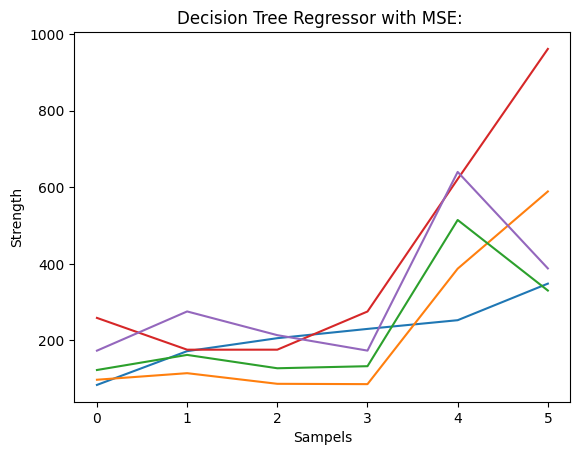

In [320]:
plt.plot(df["Ad-Distance"]*500)
plt.plot(df["K_T_DT"])
plt.plot(df["K_V_DT"])
#plt.plot(df["K_T_LS"])
#plt.plot(df["K_V_LS"])
plt.plot(df["K_T_KN"])
plt.plot(df["K_V_KN"])
plt.title('Decision Tree Regressor with MSE: ')
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()